## Model Training :

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import itertools
import numpy as np
import random
import torch.nn as nn
from torch.nn import Conv2d, MaxPool2d, AvgPool2d, ReLU, Linear, Sigmoid, Flatten, BatchNorm1d, BatchNorm2d ,Softmax ,Dropout
import torch.optim as optimizer
import matplotlib.pyplot as plt
import cv2
from torchsummary import summary

def set_seed(seed: int = 42):
    """Sets the seed for torch, numpy and random
    Args:
        seed (int): [description]
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


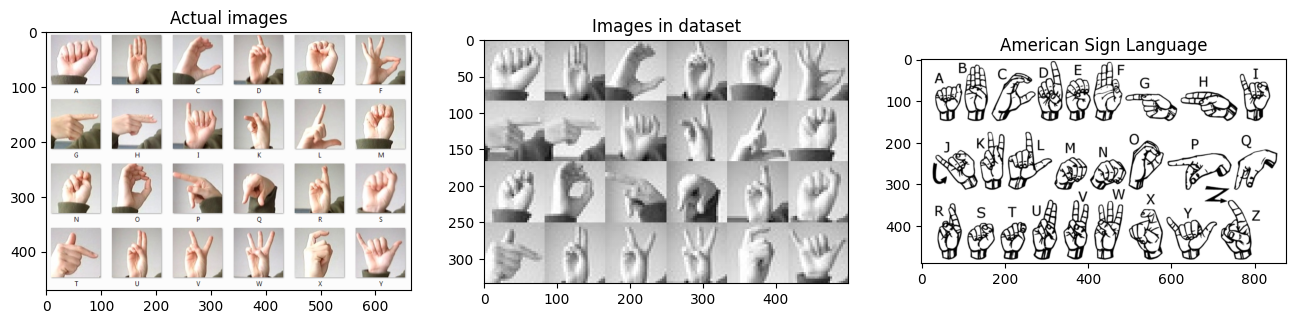

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].set_title('Actual images')
axs[0].imshow(cv2.imread('./drive/MyDrive/ML/Project/amer_sign2.png')[:, :, ::-1])

axs[1].set_title('Images in dataset')
axs[1].imshow(cv2.imread('./drive/MyDrive/ML/Project/amer_sign3.png')[:, :, ::-1])

axs[2].set_title('American Sign Language')
axs[2].imshow(cv2.imread('./drive/MyDrive/ML/Project/american_sign_language.png')[:, :, ::-1])

plt.show()

In [ ]:
class Data(Dataset):
    def __init__(self, path):
        data = pd.read_csv(path).values
        self.X = torch.Tensor(np.expand_dims(np.reshape(data[:, 1:], (-1, 28, 28)), axis=1))
        temp = np.zeros((len(data), 25), dtype=float)
        temp[np.arange(len(data)), data[:, 0]] = 1
        self.Y = torch.Tensor(temp)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
a = np.zeros((5, 10))
a

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
b = np.array([2, 7, 9, 1, 0])
a[np.arange(5), b] = 1
a

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
class MLP(nn.Module):
    def __init__(self, layer_sequence: list, use_nonlinearity: bool):
        """
        Defines an MLP with the number of nodes in each layer as specified by the node_sequence
        The first entry in the node_sequence denotes the number of neurons in the input layer.
        The last entry denotes the number of neurons in the output layer.
        To define a MLP with a single hidden layer, we will have len(nodes_sequence) = 3
        """
        super(MLP, self).__init__()

        self.model = nn.Sequential(*layer_sequence)

    def forward(self, x):
        return self.model(x)

In [ ]:
# Function to train the model
def train_model(model, lossfn, optimizer, loader, epochs, verbose=True):
    loss_history = []
    for epoch in range(epochs):
        loss_history.append([])
        running_loss = 0.0

        for x, y in loader:
            optimizer.zero_grad()
            yhat = model(x.float())
            loss = lossfn(yhat, y.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            loss_history[epoch].append(loss.item())

        if verbose and (epoch % (epochs / 10) == 0 or epoch == epochs - 1):
          epoch_loss = running_loss / len(loader.dataset)
          print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

    return loss_history

In [ ]:
# Function to evaluate the model
def evaluate_model(model, test_loader):
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            yhat = model(x.float())
            correct += torch.sum(torch.argmax(yhat, axis=1) == torch.argmax(y, axis=1))

    accuracy = correct / len(test_loader.dataset)
    return accuracy.item()

In [ ]:
def plot_epoch_loss(history):
    plt.plot(range(1, len(history) + 1), [np.mean(h) for h in history])
    plt.title('Loss History')
    plt.xlabel('Epoch number')
    plt.ylabel('Loss')
    plt.show()

In [ ]:
train_dataset = Data('./drive/MyDrive/ML/Project/data/sign_mnist_train.csv')
test_dataset = Data('./drive/MyDrive/ML/Project/data/sign_mnist_test.csv')

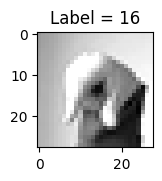

In [ ]:
plt.figure(figsize=(1.5, 1.5))
plt.title(f'Label = {torch.argmax(train_dataset[5][1])}')
plt.imshow(torch.squeeze(train_dataset[5][0]).numpy(), cmap='gray')
plt.show()

## Priyanshu

#### Trial 1

MLP(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=40, out_features=20, bias=True)
    (11): ReLU()
    (12): Linear(in_features=20, out_features=25, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              30
              ReLU-2            [-1, 3, 28, 28]               0
         Ma

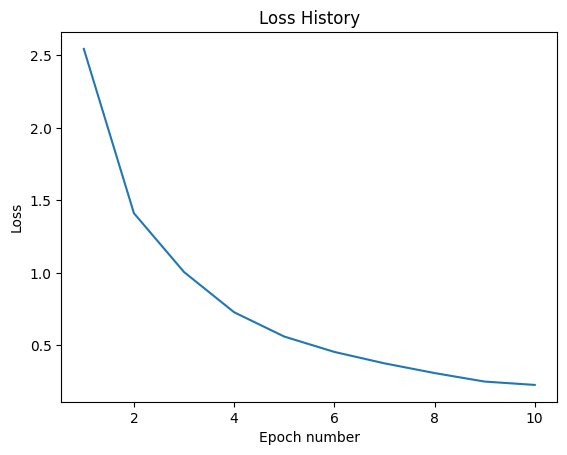

In [ ]:
set_seed()
loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

layers = [
  Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding='same'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Flatten(),
  Linear(in_features=40, out_features=20),
  ReLU(),
  Linear(in_features=20, out_features=25),
]


m = MLP(layers, use_nonlinearity=True)
print(m)
print()
summary(m, (1, 28, 28))
print()
optim = optimizer.Adam(m.parameters(), lr=0.001)
lossfn = nn.CrossEntropyLoss()
epochs=10

loss_history = train_model(m, lossfn, optim, loader, epochs)
plot_epoch_loss(loss_history)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f'Accuracy = {round(evaluate_model(m, test_loader), 4)}')

Accuracy = 0.6221


#### Trial 2 - Increasing number of epochs

MLP(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=40, out_features=20, bias=True)
    (11): ReLU()
    (12): Linear(in_features=20, out_features=25, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              30
              ReLU-2            [-1, 3, 28, 28]               0
         Ma

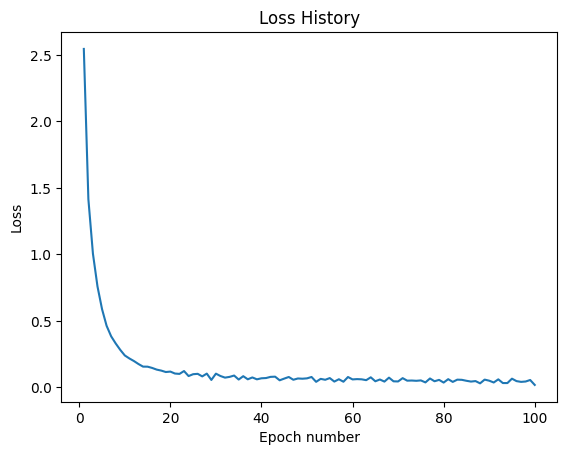

In [ ]:
set_seed()
loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

layers = [
  Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding='same'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Flatten(),
  Linear(in_features=40, out_features=20),
  ReLU(),
  Linear(in_features=20, out_features=25),
]


m = MLP(layers, use_nonlinearity=True)
print(m)
print()
summary(m, (1, 28, 28))
print()
optim = optimizer.Adam(m.parameters(), lr=0.001)
lossfn = nn.CrossEntropyLoss()
epochs=100

loss_history = train_model(m, lossfn, optim, loader, epochs)
plot_epoch_loss(loss_history)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f'Accuracy = {round(evaluate_model(m, test_loader), 4)}')

Accuracy = 0.692


#### Trial 3 - Trying an aggressive approach with high learning rate

In [ ]:
set_seed()
loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

layers = [
  Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding='same'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Flatten(),
  Linear(in_features=40, out_features=20),
  ReLU(),
  Linear(in_features=20, out_features=25),
]


m = MLP(layers, use_nonlinearity=True)
print(m)
print()
summary(m, (1, 28, 28))
print()
optim = optimizer.Adam(m.parameters(), lr=0.01)
lossfn = nn.CrossEntropyLoss()
epochs=40

loss_history = train_model(m, lossfn, optim, loader, epochs)
plot_epoch_loss(loss_history)

MLP(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=40, out_features=20, bias=True)
    (11): ReLU()
    (12): Linear(in_features=20, out_features=25, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              30
              ReLU-2            [-1, 3, 28, 28]               0
         Ma

KeyboardInterrupt: 

#### Trial 4 - Not able to see the loss going down. Taking the learning rate back to 0.001 and changing the architecture

MLP(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=45, out_features=25, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 24, 24]              78
              ReLU-2            [-1, 3, 24, 24]               0
         MaxPool2d-3            [-1, 3, 12, 12]               0
            Conv2d-4            [-1, 5, 10, 10]             140
              ReLU-5            [-1, 5, 10, 10]               

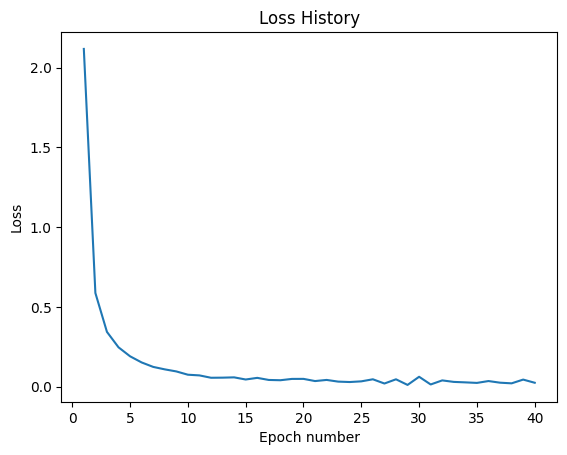

In [ ]:
set_seed()
loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

layers = [
  Conv2d(in_channels=1, out_channels=3, kernel_size=5, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=5, out_channels=5, kernel_size=3, padding='valid'),
  Flatten(),
  Linear(in_features=45, out_features=25),
]


m = MLP(layers, use_nonlinearity=True)
print(m)
print()
summary(m, (1, 28, 28))
print()
optim = optimizer.Adam(m.parameters(), lr=0.001)
lossfn = nn.CrossEntropyLoss()
epochs=40

loss_history = train_model(m, lossfn, optim, loader, epochs)
plot_epoch_loss(loss_history)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f'Accuracy = {round(evaluate_model(m, test_loader), 4)}')

Accuracy = 0.752


#### Trial 5 - Got comparatively good results above. Maybe because the parameters were less. Trying to further decrease the number of parameters

MLP(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(5, 3, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=27, out_features=25, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 24, 24]              78
              ReLU-2            [-1, 3, 24, 24]               0
         MaxPool2d-3            [-1, 3, 12, 12]               0
            Conv2d-4            [-1, 5, 10, 10]             140
              ReLU-5            [-1, 5, 10, 10]               

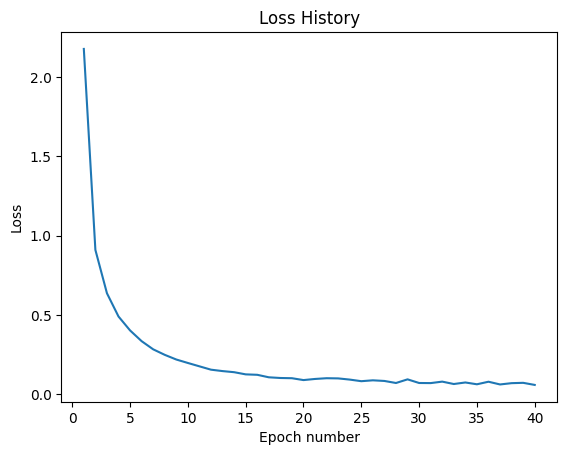

In [ ]:
set_seed()
loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

layers = [
  Conv2d(in_channels=1, out_channels=3, kernel_size=5, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=5, out_channels=3, kernel_size=3, padding='valid'),
  Flatten(),
  Linear(in_features=27, out_features=25),
]


m = MLP(layers, use_nonlinearity=True)
print(m)
print()
summary(m, (1, 28, 28))
print()
optim = optimizer.Adam(m.parameters(), lr=0.001)
lossfn = nn.CrossEntropyLoss()
epochs=40

loss_history = train_model(m, lossfn, optim, loader, epochs)
plot_epoch_loss(loss_history)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f'Accuracy = {round(evaluate_model(m, test_loader), 4)}')

Accuracy = 0.7089


#### Trial 6 - Decreasing parameters didn't work. Training the model in (4) for more epochs

MLP(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=45, out_features=25, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 24, 24]              78
              ReLU-2            [-1, 3, 24, 24]               0
         MaxPool2d-3            [-1, 3, 12, 12]               0
            Conv2d-4            [-1, 5, 10, 10]             140
              ReLU-5            [-1, 5, 10, 10]               

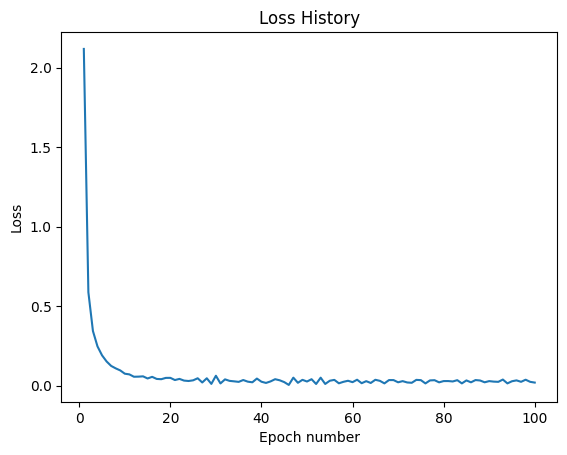

In [ ]:
set_seed()
loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

layers = [
  Conv2d(in_channels=1, out_channels=3, kernel_size=5, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=5, out_channels=5, kernel_size=3, padding='valid'),
  Flatten(),
  Linear(in_features=45, out_features=25),
]


m = MLP(layers, use_nonlinearity=True)
print(m)
print()
summary(m, (1, 28, 28))
print()
optim = optimizer.Adam(m.parameters(), lr=0.001)
lossfn = nn.CrossEntropyLoss()
epochs=100

loss_history = train_model(m, lossfn, optim, loader, epochs)
plot_epoch_loss(loss_history)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f'Accuracy = {round(evaluate_model(m, test_loader), 4)}')

Accuracy = 0.7394


#### Trial 7 - Trying SGD

MLP(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=63, out_features=25, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 24, 24]              78
              ReLU-2            [-1, 3, 24, 24]               0
         MaxPool2d-3            [-1, 3, 12, 12]               0
            Conv2d-4            [-1, 5, 10, 10]             140
              ReLU-5            [-1, 5, 10, 10]               

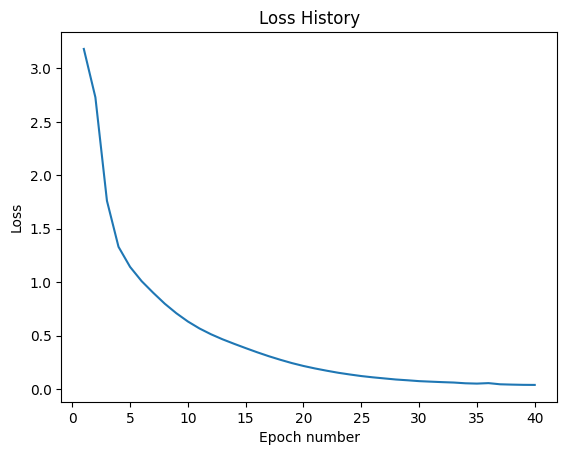

In [ ]:
set_seed()
loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

layers = [
  Conv2d(in_channels=1, out_channels=3, kernel_size=5, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=5, out_channels=7, kernel_size=3, padding='valid'),
  Flatten(),
  Linear(in_features=63, out_features=25),
]


m = MLP(layers, use_nonlinearity=True)
print(m)
print()
summary(m, (1, 28, 28))
print()
optim = optimizer.SGD(m.parameters(), lr=0.001)
lossfn = nn.CrossEntropyLoss()
epochs=40

loss_history = train_model(m, lossfn, optim, loader, epochs)
plot_epoch_loss(loss_history)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f'Accuracy = {round(evaluate_model(m, test_loader), 4)}')

Accuracy = 0.6981


#### Trial 8 - Increasing number of epochs

In [ ]:
set_seed()
loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

layers = [
  Conv2d(in_channels=1, out_channels=3, kernel_size=5, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=5, out_channels=7, kernel_size=3, padding='valid'),
  Flatten(),
  Linear(in_features=63, out_features=25),
]


m = MLP(layers, use_nonlinearity=True)
print(m)
print()
summary(m, (1, 28, 28))
print()
optim = optimizer.SGD(m.parameters(), lr=0.001)
lossfn = nn.CrossEntropyLoss()
epochs=100

loss_history = train_model(m, lossfn, optim, loader, epochs)
plot_epoch_loss(loss_history)

MLP(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=63, out_features=25, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 24, 24]              78
              ReLU-2            [-1, 3, 24, 24]               0
         MaxPool2d-3            [-1, 3, 12, 12]               0
            Conv2d-4            [-1, 5, 10, 10]             140
              ReLU-5            [-1, 5, 10, 10]               

# Jinesh

In [ ]:
### TRIAL 1 : INCREASING THE LEARNING RATE
### TRIAL 2 : BatchNormalization
### TRIAL 3 : Setting Dilation Factor = 3
### TRIAL 4 : Increased Some Features
### TRIAL 5 : Dilation with AvgPool vs MaxPool

## TRIAL 1 : CHANGING THE LEARNING RATE AND FINDING SUITABLE RATE FOR LESS LOSS COMPARED TO PREVIOUS
ACCURACY : 62.22% to 70.78%

MLP(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=40, out_features=20, bias=True)
    (11): ReLU()
    (12): Linear(in_features=20, out_features=25, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              30
              ReLU-2            [-1, 3, 28, 28]               0
         Ma

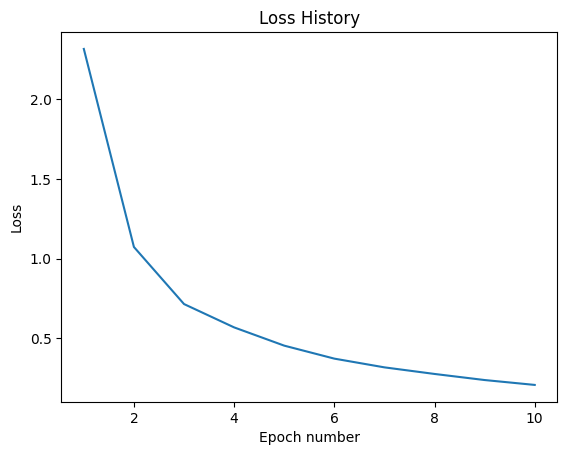

In [ ]:
set_seed()
loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

layers = [
  Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding='same'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Flatten(),
  Linear(in_features=40, out_features=20),
  ReLU(),
  Linear(in_features=20, out_features=25),
]


m = MLP(layers, use_nonlinearity=True)
print(m)
print()
summary(m, (1, 28, 28))
print()
optim = optimizer.Adam(m.parameters(), lr=0.0015)
lossfn = nn.CrossEntropyLoss()
epochs=10

loss_history = train_model(m, lossfn, optim, loader, epochs)
plot_epoch_loss(loss_history)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f'Accuracy = {round(evaluate_model(m, test_loader), 4)}')

Accuracy = 0.7078


## TRIAL 2 : BatchNormalization
ACCURACY : 70% TO 78.42%

MLP(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (5): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (9): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=40, out_features=20, bias=True)
    (14): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

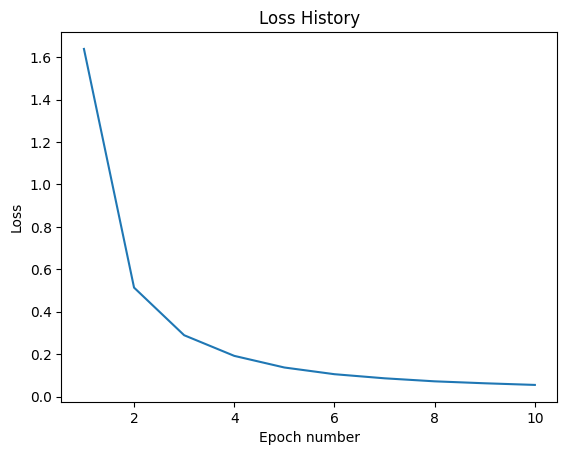

In [ ]:
set_seed()
loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

layers = [
  Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding='same'),
  BatchNorm2d(3),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding='valid'),
  BatchNorm2d(5),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding='valid'),
  BatchNorm2d(10),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Flatten(),
  Linear(in_features=40, out_features=20),
  BatchNorm1d(20),
  ReLU(),
  Linear(in_features=20, out_features=25),
]


m = MLP(layers, use_nonlinearity=True)
print(m)
print()
summary(m, (1, 28, 28))
print()
optim = optimizer.Adam(m.parameters(), lr=0.0015)
lossfn = nn.CrossEntropyLoss()
epochs=10

loss_history = train_model(m, lossfn, optim, loader, epochs)
plot_epoch_loss(loss_history)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f'Accuracy = {round(evaluate_model(m, test_loader), 4)}')

Accuracy = 0.7842


## TRIAL 3 : TESTING WITH DILATION RATE

MLP(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid, dilation=(3, 3))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=64, out_features=32, bias=True)
    (14): BatchNorm1d(32, eps=1e-05, momentum

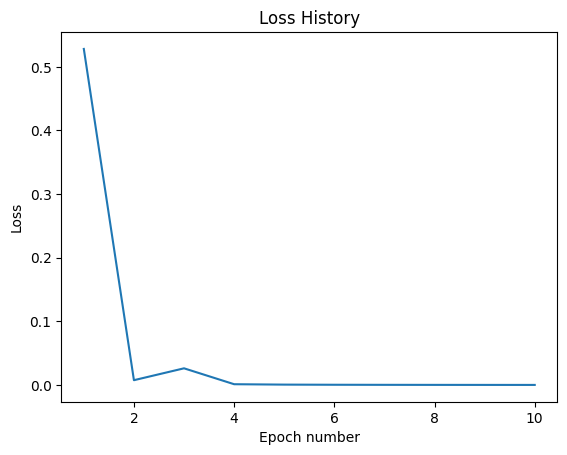

In [ ]:
set_seed()
loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

layers = [
  Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding='same',dilation =2),
  BatchNorm2d(16),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='valid',dilation =3),
  BatchNorm2d(32),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='valid'),
  BatchNorm2d(64),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Flatten(),
  Linear(in_features=64, out_features=32),
  BatchNorm1d(32),
  ReLU(),
  Linear(in_features=32, out_features=25),
]


m = MLP(layers, use_nonlinearity=True)
print(m)
print()
summary(m, (1, 28, 28))
print()
optim = optimizer.Adam(m.parameters(), lr=0.0015)
lossfn = nn.CrossEntropyLoss()
epochs=10

loss_history = train_model(m, lossfn, optim, loader, epochs)
plot_epoch_loss(loss_history)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f'Accuracy = {round(evaluate_model(m, test_loader), 4)}')

Accuracy = 0.9325


In [ ]:
set_seed()
loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

layers = [
  Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding='same',dilation =2),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  BatchNorm2d(16),
  Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='valid',dilation =3),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  BatchNorm2d(32),
  Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  BatchNorm2d(64),
  Flatten(),
  Linear(in_features=64, out_features=32),
  ReLU(),
  BatchNorm1d(32),
  Linear(in_features=32, out_features=25),
]


m = MLP(layers, use_nonlinearity=True)
print(m)
print()
summary(m, (1, 28, 28))
print()
optim = optimizer.Adam(m.parameters(), lr=0.0015)
lossfn = nn.CrossEntropyLoss()
epochs=10

loss_history = train_model(m, lossfn, optim, loader, epochs)
plot_epoch_loss(loss_history)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f'Accuracy = {round(evaluate_model(m, test_loader), 4)}')

# Vyomesh

#### Trial 1

In [ ]:
set_seed()
loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

layers = [
  Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding='same'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding='valid'),
  ReLU(),
  MaxPool2d(kernel_size=2, stride=2),
  Flatten(),
  Linear(in_features=40, out_features=20),
  ReLU(),
  Linear(in_features=20, out_features=25),
]


m = MLP(layers, use_nonlinearity=True)
print(m)
print()
summary(m, (1, 28, 28))
print()
optim = optimizer.Adam(m.parameters(), lr=0.001)
lossfn = nn.CrossEntropyLoss()
epochs=10

loss_history = train_model(m, lossfn, optim, loader, epochs)

MLP(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=40, out_features=20, bias=True)
    (11): ReLU()
    (12): Linear(in_features=20, out_features=25, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              30
              ReLU-2            [-1, 3, 28, 28]               0
         Ma

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f'Accuracy = {round(evaluate_model(m, test_loader), 4)}')

Accuracy = 0.6221


#### Trial 2 - Adjust learning rate

In [ ]:
layers = [
    nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=10*3*3, out_features=20),
    nn.ReLU(),
    nn.Linear(in_features=20, out_features=25),
]

# Create the model
m = MLP(layers, use_nonlinearity=True)
print(m)
print()

# Model summary
summary(m, (1, 28, 28))
print()

# Assuming train_dataset and loader are already defined

# Define the optimizer and loss function
optim = optimizer.Adam(m.parameters(), lr=0.0001) # adjusted learning rate
lossfn = nn.CrossEntropyLoss()

# Train the model
epochs = 10
loss_history = train_model(m, lossfn, optim, loader, epochs)

MLP(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=90, out_features=20, bias=True)
    (11): ReLU()
    (12): Linear(in_features=20, out_features=25, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              30
              ReLU-2            [-1, 3, 28, 28]               0
       

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f'Accuracy = {round(evaluate_model(m, test_loader), 4)}')

Accuracy = 0.6255


#### Trial 3 - increase number of epochs

In [ ]:
layers = [
    nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=10*3*3, out_features=20),
    nn.ReLU(),
    nn.Linear(in_features=20, out_features=25),
]

# Create the model
m = MLP(layers, use_nonlinearity=True)
print(m)
print()

# Model summary
summary(m, (1, 28, 28))
print()

# Assuming train_dataset and loader are already defined

# Define the optimizer and loss function
optim = optimizer.Adam(m.parameters(), lr=0.001)
lossfn = nn.CrossEntropyLoss()

# Train the model
epochs = 100  # Increased epochs for better chances of convergence
loss_history = train_model(m, lossfn, optim, loader, epochs)

MLP(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=90, out_features=20, bias=True)
    (11): ReLU()
    (12): Linear(in_features=20, out_features=25, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              30
              ReLU-2            [-1, 3, 28, 28]               0
       

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f'Accuracy = {round(evaluate_model(m, test_loader), 4)}')

Accuracy = 0.818


# Mikhil

#### Trial 1 : Using Average Pooling instead of Max Pooling :

MLP(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=40, out_features=20, bias=True)
    (11): ReLU()
    (12): Linear(in_features=20, out_features=25, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              30
              ReLU-2            [-1, 3, 28, 28]               0
         AvgPool2d-3            [-1, 3, 14, 14]               0
            Conv2d-4            [-

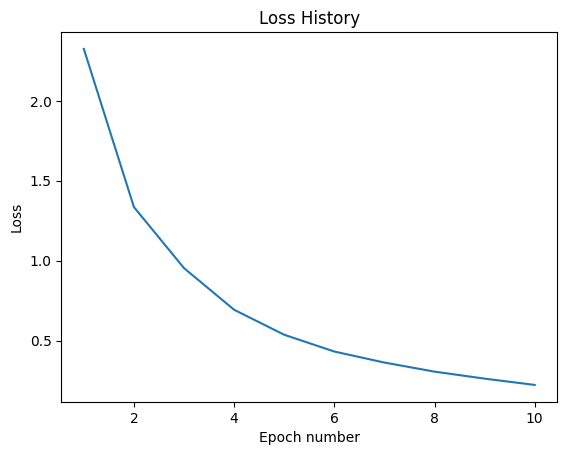

In [ ]:
set_seed()
loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

layers = [
  Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding='same'),
  ReLU(),
  AvgPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding='valid'),
  ReLU(),
  AvgPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding='valid'),
  ReLU(),
  AvgPool2d(kernel_size=2, stride=2),
  Flatten(),
  Linear(in_features=40, out_features=20),
  ReLU(),
  Linear(in_features=20, out_features=25),
]


m = MLP(layers, use_nonlinearity=True)
print(m)
print()
summary(m, (1, 28, 28))
print()
optim = optimizer.Adam(m.parameters(), lr=0.001)
lossfn = nn.CrossEntropyLoss()
epochs=10

loss_history = train_model(m, lossfn, optim, loader, epochs)
plot_epoch_loss(loss_history)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f'Accuracy = {round(evaluate_model(m, test_loader), 4)}')

Accuracy = 0.7773


Accurary increased from 62.21% to 77.73%.

#### Trial 2 : Increasing kernel size of last convolution layer

MLP(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1), padding=valid)
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=10, out_features=20, bias=True)
    (11): ReLU()
    (12): Linear(in_features=20, out_features=25, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              30
              ReLU-2            [-1, 3, 28, 28]               0
         AvgPool2d-3            [-1, 3, 14, 14]               0
            Conv2d-4            [-

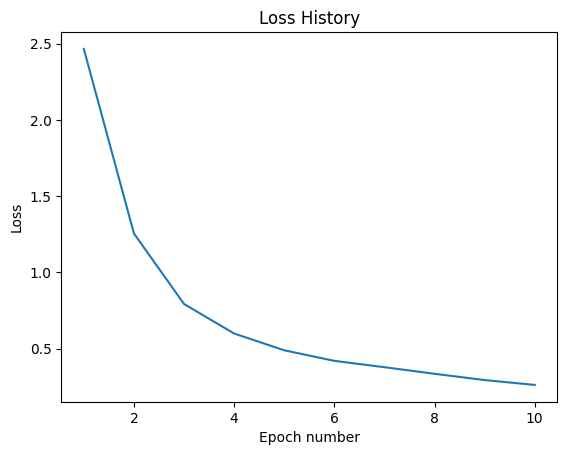

In [ ]:
set_seed()
loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

layers = [
  Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding='same'),
  ReLU(),
  AvgPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding='valid'),
  ReLU(),
  AvgPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=5, out_channels=10, kernel_size=5, padding='valid'),
  ReLU(),
  AvgPool2d(kernel_size=2, stride=2),
  Flatten(),
  Linear(in_features=10, out_features=20),
  ReLU(),
  Linear(in_features=20, out_features=25),
]


m = MLP(layers, use_nonlinearity=True)
print(m)
print()
summary(m, (1, 28, 28))
print()
optim = optimizer.Adam(m.parameters(), lr=0.001)
lossfn = nn.CrossEntropyLoss()
epochs=10

loss_history = train_model(m, lossfn, optim, loader, epochs)
plot_epoch_loss(loss_history)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f'Accuracy = {round(evaluate_model(m, test_loader), 4)}')

Accuracy = 0.7529


Accurarcy decreased by about 2% since the only 10 features were given to the FC layer which means maybe some important features were missed.

#### Trial 3 : Therefore decreasing the kernel size would mean more important features can be passed to the following layers. Also increased 1 layer of FC.

MLP(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(5, 10, kernel_size=(1, 1), stride=(1, 1), padding=valid)
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=90, out_features=110, bias=True)
    (11): ReLU()
    (12): Linear(in_features=110, out_features=50, bias=True)
    (13): ReLU()
    (14): Linear(in_features=50, out_features=25, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              30
              ReLU-2            [-1, 3, 28, 28]               0
         AvgPool2d

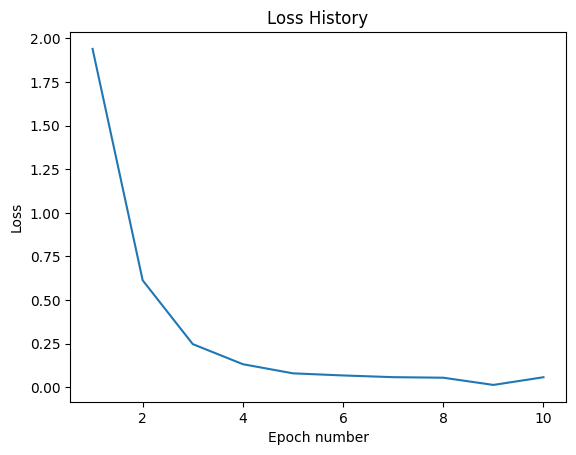

In [ ]:
set_seed()
loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

layers = [
  Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding='same'),
  ReLU(),
  AvgPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding='valid'),
  ReLU(),
  AvgPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=5, out_channels=10, kernel_size=1, padding='valid'),
  ReLU(),
  AvgPool2d(kernel_size=2, stride=2),
  Flatten(),
  Linear(in_features=90, out_features=110),
  ReLU(),
  Linear(in_features=110, out_features=50),
  ReLU(),
  Linear(in_features=50, out_features=25),
]


m = MLP(layers, use_nonlinearity=True)
print(m)
print()
summary(m, (1, 28, 28))
print()
optim = optimizer.Adam(m.parameters(), lr=0.001)
lossfn = nn.CrossEntropyLoss()
epochs=10

loss_history = train_model(m, lossfn, optim, loader, epochs)
plot_epoch_loss(loss_history)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f'Accuracy = {round(evaluate_model(m, test_loader), 4)}')

Accuracy = 0.8496


Accuracy improved from 75% to 85%.
Here 90 feature points were calculated which increased number of important features for a more accurate prediction.

#### Trial 4 : Increasing number of filters so now after the last convolutional layer there would be 180 feature points.

MLP(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(5, 20, kernel_size=(1, 1), stride=(1, 1), padding=valid)
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=180, out_features=300, bias=True)
    (11): ReLU()
    (12): Linear(in_features=300, out_features=100, bias=True)
    (13): ReLU()
    (14): Linear(in_features=100, out_features=25, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              30
              ReLU-2            [-1, 3, 28, 28]               0
         AvgPoo

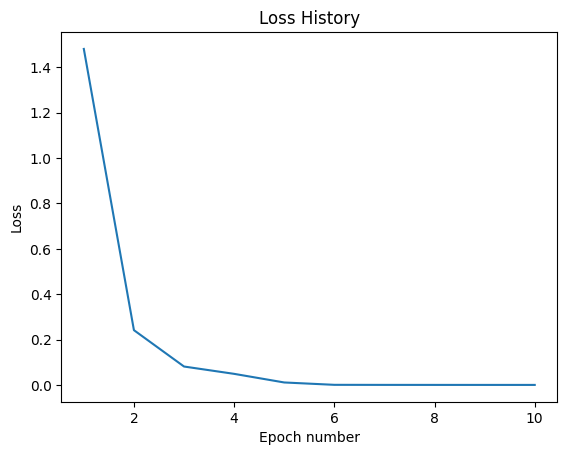

In [ ]:
set_seed()
loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

layers = [
  Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding='same'),
  ReLU(),
  AvgPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding='valid'),
  ReLU(),
  AvgPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=5, out_channels=20, kernel_size=1, padding='valid'),
  ReLU(),
  AvgPool2d(kernel_size=2, stride=2),
  Flatten(),
  Linear(in_features=180, out_features=300),
  ReLU(),
  Linear(in_features=300, out_features=100),
  ReLU(),
  Linear(in_features=100, out_features=25),
]


m = MLP(layers, use_nonlinearity=True)
print(m)
print()
summary(m, (1, 28, 28))
print()
optim = optimizer.Adam(m.parameters(), lr=0.001)
lossfn = nn.CrossEntropyLoss()
epochs=10

loss_history = train_model(m, lossfn, optim, loader, epochs)
plot_epoch_loss(loss_history)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f'Accuracy = {round(evaluate_model(m, test_loader), 4)}')

Accuracy = 0.8723


Accuracy increased only by 3% even though loss was reduced to almost 0.

#### Trial 5 : Increasing the number of epochs

MLP(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(5, 20, kernel_size=(1, 1), stride=(1, 1), padding=valid)
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=180, out_features=300, bias=True)
    (11): ReLU()
    (12): Linear(in_features=300, out_features=100, bias=True)
    (13): ReLU()
    (14): Linear(in_features=100, out_features=25, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              30
              ReLU-2            [-1, 3, 28, 28]               0
         AvgPoo

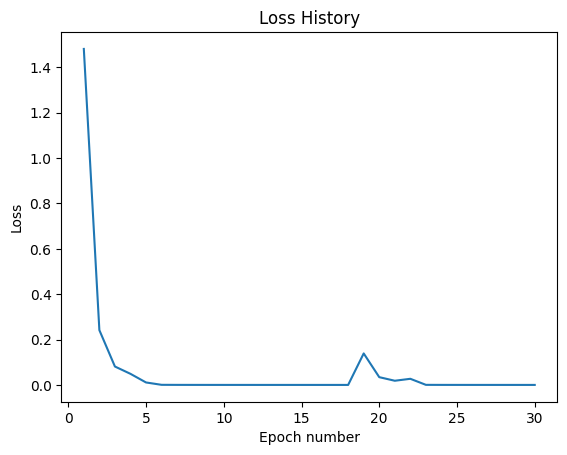

In [ ]:
set_seed()
loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

layers = [
  Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding='same'),
  ReLU(),
  AvgPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding='valid'),
  ReLU(),
  AvgPool2d(kernel_size=2, stride=2),
  Conv2d(in_channels=5, out_channels=20, kernel_size=1, padding='valid'),
  ReLU(),
  AvgPool2d(kernel_size=2, stride=2),
  Flatten(),
  Linear(in_features=180, out_features=300),
  ReLU(),
  Linear(in_features=300, out_features=100),
  ReLU(),
  Linear(in_features=100, out_features=25),
]


m = MLP(layers, use_nonlinearity=True)
print(m)
print()
summary(m, (1, 28, 28))
print()
optim = optimizer.Adam(m.parameters(), lr=0.001)
lossfn = nn.CrossEntropyLoss()
epochs=30

loss_history = train_model(m, lossfn, optim, loader, epochs)
plot_epoch_loss(loss_history)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f'Accuracy = {round(evaluate_model(m, test_loader), 4)}')

Accuracy = 0.8723


Increasing epochs did nothing to improve the accuracy and instead caused a loss spike near the end which indicates many things but could be overfitting.